# Sensitivity Analysis accounting for climate change 

In [1]:
#Imports 
import pvlib
from pvlib.location import Location
from pvlib import pvsystem, location, modelchain, iotools
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import pathlib
from datetime import datetime
from dataclasses import dataclass
import sqlite3
import scipy
from eto import ETo
import matplotlib.patches as mpatches


In [2]:

#loading weather data file 
con = sqlite3.connect('solarData.sqlite')
df_weather_CEBIVE_raw = pd.read_sql_query("SELECT * from cebiveSolarDailyHourly", con)
df_precipitation_CEBIVE_raw = pd.read_sql_query("SELECT date, rain_1h from cebiveWeatherHourly", con)
con.close()

df_weather_CEBIVE = df_weather_CEBIVE_raw.groupby('date').agg({'Temp': ['max', 'min'], 'RH': ['max', 'min'], 'pressure': 'mean', 'wind_speed': 'mean', 'Cloudy_sky.ghi': 'sum', 'Cloudy_sky.dni':'sum' })
df_weather_CEBIVE.columns = ['T_max', 'T_min', 'RH_max', 'RH_min' ,'P','U_2', 'GHI', 'DNI']
df_weather_CEBIVE['R_n'] = (0.77 * df_weather_CEBIVE['GHI'] + 0.25 * df_weather_CEBIVE['DNI']) * 3600 / 1e6 #in MJ/m2/day
df_weather_CEBIVE.drop(columns=['GHI', 'DNI'])
df_weather_CEBIVE.index = pd.to_datetime(df_weather_CEBIVE.index)
df_precipitation_CEBIVE_raw['rain_1h'] = pd.to_numeric(df_precipitation_CEBIVE_raw['rain_1h'], errors='coerce')
df_precipitation_CEBIVE_raw['rain_1h'].astype(float)
df_precipitation_CEBIVE = df_precipitation_CEBIVE_raw.groupby('date').sum()
df_precipitation_CEBIVE.index = pd.to_datetime(df_precipitation_CEBIVE.index)


In [3]:
# Yaque del Sur rainfall differences (https://surfuturo.org/storage/app/uploads/public/635/167/62b/63516762bc3c6485770914.pdf)

months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 
rain_2010 = [28.5, 25.5, 21.3, 106.5, 217.1, 84.2, 158.7, 113.7, 106.4, 54.8, 40.4, 10.8]  # Rain amounts in mm for 2010
rain_2050 = [30.9, 38.3, 54.6, 80.0, 143.5, 40.7, 128.5, 118.9, 91.4, 198.8, 44.1, 6]  # Rain amounts in mm for 2050
tempmax_2010 = [27.7, 27.2, 27.5, 31.2, 28.5, 31, 32, 31, 28.7, 28.9, 27, 24.9] #C 
tempmax_2050 = [28.5, 28, 29, 32, 30.1, 31.9, 33.6, 31.7, 28.9, 29.7, 27.8, 26.6] #C
df_Yaque = pd.DataFrame({'Month': months,'Rain_2010': rain_2010, 'Rain_2050': rain_2050, 'tempmax_2010': tempmax_2010, 'tempmax_2050': tempmax_2050})

df_Yaque['percent_change_rain'] = (df_Yaque['Rain_2050'] - df_Yaque['Rain_2010']) / df_Yaque['Rain_2010'] * 100 
df_Yaque['percent_change_tempmax'] = (df_Yaque['tempmax_2050'] - df_Yaque['tempmax_2010']) / df_Yaque['tempmax_2010'] * 100

df_Yaque.set_index('Month', inplace=True)
df_Yaque


,Rain_2010,Rain_2050,tempmax_2010,tempmax_2050,percent_change_rain,percent_change_tempmax
Month,,,,,,
1,28.5,30.9,27.7,28.5,8.421053,2.888087
2,25.5,38.3,27.2,28.0,50.196078,2.941176
3,21.3,54.6,27.5,29.0,156.338028,5.454545
4,106.5,80.0,31.2,32.0,-24.882629,2.564103
5,217.1,143.5,28.5,30.1,-33.901428,5.614035
6,84.2,40.7,31.0,31.9,-51.662708,2.903226
7,158.7,128.5,32.0,33.6,-19.029616,5.000000
8,113.7,118.9,31.0,31.7,4.573439,2.258065
9,106.4,91.4,28.7,28.9,-14.097744,0.696864


In [4]:
#Only 2010 values 
df_2010_precipitation = df_precipitation_CEBIVE['2010-01-01':'2010-12-31']
df_2010_weather = df_weather_CEBIVE['2010-01-01':'2010-12-31']


In [16]:
df_2010_precipitation['Month'] = df_2010_precipitation.index.month
df_2010_precipitation['Month']

/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/1451493581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010_precipitation['Month'] = df_2010_precipitation.index.month


date
2010-01-01     1
2010-01-02     1
2010-01-03     1
2010-01-04     1
2010-01-05     1
              ..
2010-12-27    12
2010-12-28    12
2010-12-29    12
2010-12-30    12
2010-12-31    12
Name: Month, Length: 365, dtype: int32

In [13]:
df_Yaque

,Rain_2010,Rain_2050,tempmax_2010,tempmax_2050,percent_change_rain,percent_change_tempmax
Month,,,,,,
1,28.5,30.9,27.7,28.5,8.421053,2.888087
2,25.5,38.3,27.2,28.0,50.196078,2.941176
3,21.3,54.6,27.5,29.0,156.338028,5.454545
4,106.5,80.0,31.2,32.0,-24.882629,2.564103
5,217.1,143.5,28.5,30.1,-33.901428,5.614035
6,84.2,40.7,31.0,31.9,-51.662708,2.903226
7,158.7,128.5,32.0,33.6,-19.029616,5.000000
8,113.7,118.9,31.0,31.7,4.573439,2.258065
9,106.4,91.4,28.7,28.9,-14.097744,0.696864


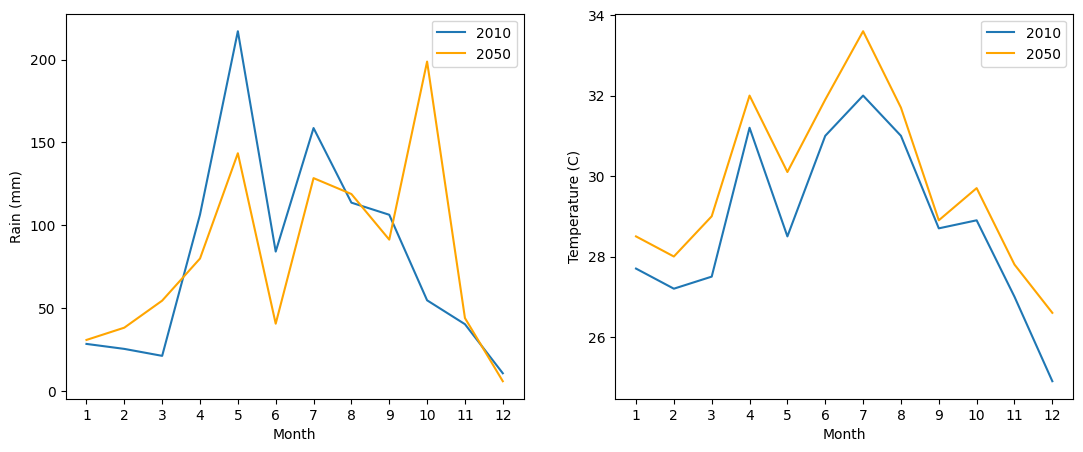

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

axs[0].plot(df_Yaque['Rain_2010'], label='2010', color='tab:blue' )
axs[0].plot(df_Yaque['Rain_2050'], label='2050', color='orange')
axs[0].set_ylabel('Rain (mm)')
axs[0].set_xlabel('Month')
axs[0].set_xticks(np.arange(1, 13, 1))
axs[0].legend()

axs[1].plot(df_Yaque['tempmax_2010'], label='2010', color='tab:blue' )
axs[1].plot(df_Yaque['tempmax_2050'], label='2050', color='orange')
axs[1].set_ylabel('Temperature (C)')
axs[1].set_xlabel('Month')
axs[1].set_xticks(np.arange(1, 13, 1))
axs[1].legend()
#fig.set_xlabels('Month')
plt.show()

In [28]:

# create snesitivity analysis values for precipitation
df_SA_percipitation = pd.merge(df_2010_precipitation, df_Yaque, left_on='Month', right_index=True, how='left')
df_SA_percipitation['Rain_SA'] = df_SA_percipitation['rain_1h'] * (1+ (df_SA_percipitation['percent_change_rain'] / 100))
df_SA_percipitation.drop(columns=['Month', 'percent_change_rain', 'tempmax_2010', 'tempmax_2050', 'Rain_2010', 'Rain_2050', 'percent_change_tempmax'], inplace=True)


# create snesitivity analysis values for weather (T_max)
df_2010_weather['month'] = df_2010_weather.index.month
df_SA_weather = pd.merge(df_2010_weather, df_Yaque, left_on='month', right_index=True, how='left')
df_SA_weather['T_max_SA'] = df_SA_weather['T_max'] * (1+ (df_SA_weather['percent_change_tempmax'] / 100))
df_SA_weather.drop(columns=[ 'percent_change_tempmax', 'tempmax_2010', 'tempmax_2050', 'Rain_2010', 'Rain_2050', 'percent_change_rain', "T_max"], inplace=True)
df_SA_weather['T_max'] = df_SA_weather['T_max_SA']
df_SA_weather.drop(columns=['T_max_SA', 'month'], inplace=True)

# Reorder the columns
last_column = df_SA_weather.columns[-1]
df_SA_weather = df_SA_weather[[last_column] + [col for col in df_SA_weather.columns if col != last_column]]
df_SA_weather




/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/1373000038.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010_weather['month'] = df_2010_weather.index.month


,T_max,T_min,RH_max,RH_min,P,U_2,GHI,DNI,R_n
date,,,,,,,,,
2010-01-01,31.998195,22.7,93.63,51.46,1018.083333,2.175000,4257.0,5082.0,16.374204
2010-01-02,32.306859,23.5,87.16,49.48,1014.583333,1.129167,4009.0,4762.0,15.398748
2010-01-03,29.220217,23.3,96.27,65.83,1014.041667,1.937500,1457.0,880.0,4.830804
2010-01-04,30.660650,23.1,95.53,58.61,1014.500000,1.762500,3369.0,3841.0,12.795768
2010-01-05,31.586643,23.4,94.39,47.34,1015.791667,1.479167,4557.0,5862.0,17.907804
...,...,...,...,...,...,...,...,...,...
2010-12-27,29.911647,23.1,91.55,62.14,1016.541667,1.591667,2376.0,954.0,7.444872
2010-12-28,29.697992,21.2,89.87,55.00,1017.666667,3.825000,4186.0,4011.0,15.213492
2010-12-29,29.697992,19.7,85.55,49.32,1017.458333,3.687500,3744.0,4109.0,14.076468


In [29]:
df_2010_precipitation

,rain_1h,Month
date,,
2010-01-01,0.00,1
2010-01-02,0.93,1
2010-01-03,0.41,1
2010-01-04,1.10,1
2010-01-05,0.00,1
...,...,...
2010-12-27,3.25,12
2010-12-28,0.65,12
2010-12-29,0.00,12


/usr/local/lib/python3.11/site-packages/eto/param_est.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ts_param['e_a'].loc[self.ts_param['e_a'].isnull()] = (self.ts_param['e_min'][self.ts_param['e_a'].isnull()] * self.ts_param.loc[self.ts_param['e_a'].isnull(), 'RH_max']/100 + self.ts_param['e_max'][self.ts_param['e_a'].isnull()] * self.ts_param.loc[self.ts_param['e_a'].isnull(), 'RH_min']/100)/2
/usr/local/lib/python3.11/site-packages/eto/param_est.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ts_param['e_a'].loc[self.ts_param['e_a'].isnull()] = self.ts_param.loc[self.ts_param['e_a'].isnull(), '

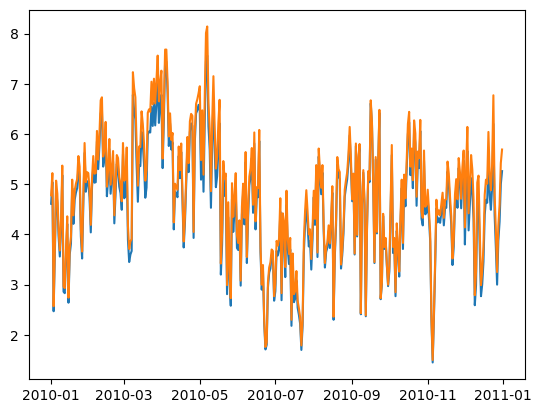

In [30]:
#EvapoTranspiration calculation

# 2010 (Normal)
et1 = ETo()
et1.param_est(df= df_2010_weather, freq='D', z_msl=10, lat=18.54, lon=-69.99, TZ_lon=-60.00, z_u=2, K_rs=0.16, a_s=0.25, b_s=0.5, alb=0.23)
et1.ts_param.head()
ETo_results_2010 = et1.eto_fao()
max_ETo_2010 = max(ETo_results_2010)


# 2050 (sensitivity analysis)]
et2 = ETo()
et2.param_est(df= df_SA_weather, freq='D', z_msl=10, lat=18.54, lon=-69.99, TZ_lon=-60.00, z_u=2, K_rs=0.16, a_s=0.25, b_s=0.5, alb=0.23)
et2.ts_param.head()
ETo_results_SA = et2.eto_fao()
max_ETo_SA = max(ETo_results_SA)

plt.plot(ETo_results_2010)
plt.plot(ETo_results_SA)


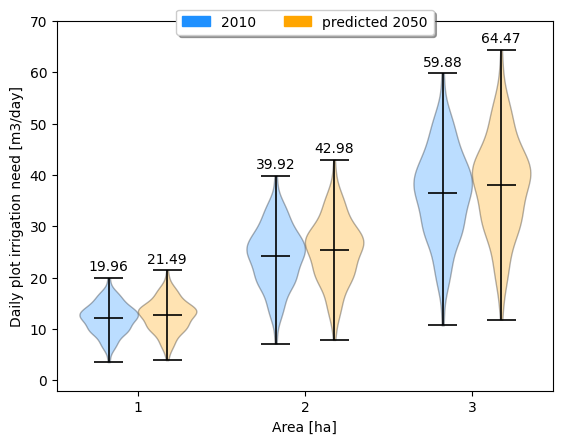

In [32]:
#For plantains 
kc_plantains = 0.88 #Goenaga et al (1995)
A_1 = 10000 #1 ha = 10000 m2 
f_w = 0.3

# 2010
df_2010 = pd.DataFrame()
df_2010['ETc_plantains'] = kc_plantains * ETo_results_2010 #mm/day
df_2010['rainfall'] = df_2010_precipitation['rain_1h'] #mm/day

df_2010['effective_rainfall'] = np.where(df_2010['rainfall'] > 2.5, (0.8 * df_2010['rainfall'] - 25)/30, (0.6* df_2010['rainfall'] - 10)/30) 
df_2010['effective_rainfall'] = np.where(df_2010['effective_rainfall'] < 0, 0, df_2010['effective_rainfall']) #can never be less than zero 
df_2010['irrigation need'] = df_2010['ETc_plantains'] - df_2010['effective_rainfall'] #mm/day
df_2010['irrigation need'] = np.where(df_2010['irrigation need'] < 0, 0, df_2010['irrigation need']) #can never be less than zero 
df_areas_2010 = pd.DataFrame()
df_areas_2010['1 ha'] = (A_1 *1 * df_2010['irrigation need']*f_w) / 1000 #m3/day
df_areas_2010['2 ha'] = (A_1 *2 * df_2010['irrigation need']*f_w) / 1000 #m3/day
df_areas_2010['3 ha'] = (A_1 *3 * df_2010['irrigation need']*f_w) / 1000 #m3/day

#SA 
df_SA = pd.DataFrame()
df_SA['ETc_plantains'] = kc_plantains * ETo_results_SA #mm/day
df_SA['rainfall'] = df_SA_percipitation['Rain_SA'] #mm/day
df_SA['effective_rainfall'] = np.where(df_SA['rainfall'] > 2.5, (0.8 * df_SA['rainfall'] - 25)/30, (0.6* df_SA['rainfall'] - 10)/30) 
df_SA['effective_rainfall'] = np.where(df_SA['effective_rainfall'] < 0, 0, df_SA['effective_rainfall']) #can never be less than zero 
df_SA['irrigation need'] = df_SA['ETc_plantains'] - df_SA['effective_rainfall'] #mm/day
df_SA['irrigation need'] = np.where(df_SA['irrigation need'] < 0, 0, df_SA['irrigation need']) #can never be less than zero
df_areas_SA = pd.DataFrame()
df_areas_SA['1 ha'] = (A_1 *1 * df_SA['irrigation need']*f_w) / 1000 #m3/day
df_areas_SA['2 ha'] = (A_1 *2 * df_SA['irrigation need']*f_w) / 1000 #m3/day
df_areas_SA['3 ha'] = (A_1 *3 * df_SA['irrigation need']*f_w) / 1000 #m3/day




import matplotlib.pyplot as plt
import numpy as np

# Define the width of each violin plot
width = 0.35

# Define the x-coordinates for each group of violins
x_areas_2010 = np.array([1, 2, 3]) - width / 2
x_sa = np.array([1, 2, 3]) + width / 2

# Plot for df_areas_2010
colors = ['dodgerblue', 'dodgerblue', 'dodgerblue']
data_areas_2010 = [df_areas_2010['1 ha'], df_areas_2010['2 ha'], df_areas_2010['3 ha']]
parts_areas_2010 = plt.violinplot(data_areas_2010, positions=x_areas_2010, widths=width, showmeans=True)

# Plot for df_SA
colors_sa = ['orange', 'orange', 'orange']
data_sa = [df_areas_SA['1 ha'], df_areas_SA['2 ha'], df_areas_SA['3 ha']]
parts_sa = plt.violinplot(data_sa, positions=x_sa, widths=width, showmeans=True)

# Set labels and ticks
plt.ylabel('Daily plot irrigation need [m3/day]')
plt.xlabel('Area [ha]')
plt.xticks([1, 2, 3], ['1', '2', '3'])

# Set colors for df_SA violin plot
for pc, color in zip(parts_sa['bodies'], colors_sa):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')

# Set colors for df_areas_2010 violin plot
for pc, color in zip(parts_areas_2010['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
   

# Set properties for other parts
for partname in ('cbars', 'cmeans', 'cmaxes', 'cmins'):
    vp = parts_sa[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1.2) 
for partname in ('cbars', 'cmeans', 'cmaxes', 'cmins'):
    vp = parts_areas_2010[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1.2) 

# Annotate maximum values for df_SA
for i, d in enumerate(data_sa):
    max_value = np.max(d)
    plt.annotate(f'{max_value:.2f}', xy=(x_sa[i], max_value), xytext=(0, +5), textcoords='offset points', ha='center', color='black')

# Annotate maximum values for df_2010
for i, d in enumerate(data_areas_2010):
    max_value = np.max(d)
    plt.annotate(f'{max_value:.2f}', xy=(x_areas_2010[i], max_value), xytext=(0, +5), textcoords='offset points', ha='center', color='black')

# Create legend
blue_patch = mpatches.Patch(color='dodgerblue',  label='2010')
orange_patch = mpatches.Patch(color='orange', label='predicted 2050')
plt.legend(handles=[blue_patch, orange_patch], loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

# Set y-axis properties
plt.yticks(np.arange(0, 75, 10))
plt.ylim(-2, 70)

plt.show()


# Sizing the system for 2050 

In [33]:
#Import and clean Solar data 
con = sqlite3.connect("../NetworkCode/SolarData.sqlite")
df_weather_CEBIVE_raw = pd.read_sql_query("SELECT * from cebiveSolarDailyHourly", con)
con.close()

#Convert date to datetime
df_weather_CEBIVE_raw['iso_date'] = pd.to_datetime(df_weather_CEBIVE_raw['iso_date'])
df_weather_CEBIVE_raw.index = pd.to_datetime(df_weather_CEBIVE_raw['iso_date'])

#create full weather data set
df_weather_full = df_weather_CEBIVE_raw[(df_weather_CEBIVE_raw['location'] == 'CEBIVE')]
df_weather_full.index = pd.to_datetime(df_weather_full['iso_date'])
df_weather_full = df_weather_full[df_weather_full['Year'] == '2010'] #only 2010 data

#Increase temperature as a result of climate change 
merged_df = pd.merge(df_weather_full, df_Yaque, on='Month', how='left')
merged_df['Temp'] = merged_df['Temp'] * (1 + merged_df['percent_change_tempmax'] / 100)
merged_df = merged_df.set_index('iso_date')
#Correcy formating 
weather_full = pd.DataFrame({
    'ghi': merged_df['Cloudy_sky.ghi'], 'dhi': merged_df['Cloudy_sky.dhi'], 'dni': merged_df['Cloudy_sky.dni'],
    'temp_air':  merged_df['Temp'], 'wind_speed':  merged_df['wind_speed']
}, index = merged_df.index)

loc = location.Location(18.541, -69.990, -4.00, 32.0) #CEBIVE

In [46]:
# Lithium-ion battery characterisitics 

eta_charge = 0.95
eta_discharge = 0.95
SOC_min = 0.05 #5%
SOC_initial = 0.95 #100%
SOC_max = 0.95 #90%
deprciation = 0.001632 #depreciation per day for 8% per month
capacity = 0.1 #kWh

### 1 ha 

In [61]:
max_flow_rate = (2*50*34) /(1000*3600) #m3/s for 1 ha 
#Pump P vs Q equation from PumpCurve.ipynb --> P = a*Q^3 + b*Q^2 + c*Q + c
a = 445687894.591783
b = -984696.5871017637
c = 854.0710206707552
d = -0.05692714507987253

max_power = a*(max_flow_rate**3) + b*(max_flow_rate**2) + c*max_flow_rate + d #kw

def root_pump_curve(a,b,c,d,P,Q):
    '''function Return zero in terms of Q of pump power equation given a,b,c,d and P'''
    return (a*(Q**3) + b*(Q**2) + c*Q + d - P)


#### Direct drive 


In [35]:
flag = 0 # flag == 0 --> insufficient number of panels, flag == 1 --> sufficient number of panels found 
n_panels = 1 # number of panels to use

while flag == 0: 
    count = 0 
    #Calculate solar panel power production for all days with n panels
    loc = location.Location(18.541, -69.990, -4.00, 32.0) #CEBIVE
    solpos = loc.get_solarposition(weather_full.index)
    module_parameters = {'pdc0': 0.35, 'gamma_pdc': -0.004, 'b': 0.05} #350W pannel 
    temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

    array_full = pvsystem.Array(mount=pvsystem.FixedMount(20, 180),
                        module_parameters=module_parameters,
                        temperature_model_parameters=temp_params, modules_per_string=n_panels)
    system_full = pvsystem.PVSystem(arrays=[array_full], inverter_parameters={'pdc0': 5, 'eta_inv_nom':0.95, 'strings_per_inverter':1 })
    mc_full = modelchain.ModelChain(system_full, loc, spectral_model='no_loss')
    _ = mc_full.run_model(weather_full)

    df_solar_full = pd.DataFrame({'solar_power': mc_full.results.ac})

    #Calculate the flow rate [m3/s] for each hour for variable speed pump 
    df_solar_full['flow_rate'] = 0 #initialize column
    # Iterate over the index of df_solar_full directly
    for hour in df_solar_full.index:
        if df_solar_full.loc[hour, 'solar_power'] >= max_power:
            df_solar_full.loc[hour, 'flow_rate'] = max_flow_rate
        elif df_solar_full.loc[hour, 'solar_power'] == 0:
            #Handle the case when solar power is zero 
            df_solar_full.loc[hour, 'flow_rate'] = 0
        else:
            # Use root_scalar to find the root of the pump curve equation
            solution = scipy.optimize.root_scalar(lambda x: root_pump_curve(a, b, c, d, df_solar_full.loc[hour, 'solar_power'], x), x0=max_flow_rate)
            df_solar_full.loc[hour, 'flow_rate'] = solution.root

    # SAFETY: Check for negative flow rates
    negative_flow_rates = df_solar_full[df_solar_full['flow_rate'] < 0]
    if not negative_flow_rates.empty:
        raise ValueError(f"Negative flow rates found in hours: {negative_flow_rates.index.tolist()}")


    # Assuming constant flow rate over each hour, calculate the total daily pumpible water 
    df_solar_full['flow_rate_hourly']= df_solar_full['flow_rate'] * 3600
    daily_flow_rates = df_solar_full['flow_rate_hourly'].resample('D').sum()
    df_areas_SA['1ha variable speed'] = daily_flow_rates

    
    #Is the possible irrigaiation with variable speed operation sufficient  with n_panels? 
    day_flag = 0 # flag == 0 --> insufficient number of panels, flag == 1 --> sufficient number of panels found
    for day in df_areas_SA.index:
        if df_areas_SA['1 ha'].loc[day] > df_areas_SA['1ha variable speed'].loc[day]:
            #print(f'{n_panels} panel(s) is not sufficient with variable speed operation, on {day} the irrigation deficit is {df_daily_irrigation["1 ha"].loc[day] - df_daily_irrigation["1ha variable speed"].loc[day]} m3')
            count += 1
            day_flag = 1
        
    if day_flag == 1:
        print(f'{count} days are not covered with variable speed direct-drive operation with {n_panels} panels')
        n_panels += 1
    else:
        flag = 1
        print(f'{n_panels} panel(s) is sufficient with variable speed operation')

    if n_panels > 10: #safety check
        raise ValueError('the number of PV panels required is greater than 10')         


#Takes a bit over 4 mins to run

/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/1355572652.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0001528050171676632' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


117 days are not covered with variable speed direct-drive operation with 1 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/1355572652.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0003291179292360715' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


4 days are not covered with variable speed direct-drive operation with 2 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/1355572652.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '7.715603724853902e-05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


2 days are not covered with variable speed direct-drive operation with 3 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/1355572652.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9.265599177240723e-05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


1 days are not covered with variable speed direct-drive operation with 4 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/1355572652.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00010878508272888393' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


5 panel(s) is sufficient with variable speed operation


#### Battery 

In [48]:
# Find minimum number of batteries required to cover all historical days 1 through 5 PV pannels 

for n_panels_battery in range(1, 6): #number of panels
    n_batteries = 0 #number of batteries in the string 
    flag = 0 #flag == 0 --> insufficient battery capacity found, flag == 1 --> sufficient battery capacity found

    #Calculate solar power output with n_pannels_battery
    loc = location.Location(18.541, -69.990, -4.00, 32.0) #CEBIVE
    solpos = loc.get_solarposition(weather_full.index)
    module_parameters = {'pdc0': 0.35, 'gamma_pdc': -0.004, 'b': 0.05} #350W pannel 
    temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

    array_full = pvsystem.Array(mount=pvsystem.FixedMount(20, 180),
                        module_parameters=module_parameters,
                        temperature_model_parameters=temp_params, modules_per_string=n_panels_battery)
    system_full = pvsystem.PVSystem(arrays=[array_full], inverter_parameters={'pdc0': 5, 'eta_inv_nom':0.95, 'strings_per_inverter':1 })
    mc_full = modelchain.ModelChain(system_full, loc, spectral_model='no_loss')
    _ = mc_full.run_model(weather_full)
    df_solar_battery = pd.DataFrame({'solar_power': mc_full.results.ac})
    

    #find minimum number of batteries needed to cover all historical days 
    while flag == 0:
        battery_capacity = capacity * n_batteries #kWh
        min_SOC = SOC_min * battery_capacity
        max_SOC = SOC_max * battery_capacity
        E_stored = [battery_capacity] #kWh, battery energy stored over time, initially full 
        day_flag = 0 
        for day, data in df_solar_battery.groupby(df_solar_battery.index.date):
            Q_day = 0 # m3 of water irrigated on day 
            Q_needed = df_areas_SA['1 ha'].loc[day.strftime('%Y-%m-%d')] #required irrigation in m3 
            power_day = df_solar_battery['solar_power'].loc[day.strftime('%Y-%m-%d')]
            
            for hour in data.index.hour:
                deficit = Q_needed - Q_day
                power = power_day.iloc[hour] #Power available to pump on that hour

                if deficit > 0: #Need to irrigate more water
                    if (power >= max_power) & (deficit > max_flow_rate * 3600): #Power is greater than max power so irrigate max possinle amount 
                        Q_day += max_flow_rate * 3600
                        E_storable = (power- max_power) * eta_charge #kWh
                    elif (power >= max_power) & (deficit <= max_flow_rate * 3600): #power is greater than max power but dont need to pump max amount
                        P_used = a * (deficit/3600)**3 + b * (deficit/3600)**2 + c * (deficit/3600) + d #power used to pump
                        Q_day += deficit
                        E_storable = (power- P_used) * eta_charge #kWh    
                    elif (power == 0): 
                        E_storable = 0 #no energy stored
                        Q_day += 0
                    elif (power < max_power): #power is less than max power, but still need to pump 
                        Q_possible = scipy.optimize.root_scalar(lambda x: root_pump_curve(a, b, c, d, power, x), x0=max_flow_rate)
                        E_storable = 0 #no energy stored
                        if Q_possible.root*3600 >= deficit:
                            Q_day += deficit
                        else:
                            Q_day += Q_possible.root * 3600
                    

                else: #dont need to irrigate more
                    E_storable =power*eta_charge 

                #Store energy
                if (E_storable + E_stored[-1]*(1-deprciation)) <= max_SOC:
                    E_stored.append(E_stored[-1]*(1-deprciation) + E_storable) #kWh
                else: #if more energy than battery can store, only store what battery can store
                    E_stored.append(max_SOC) #kWh
                
            
                
            if deficit > 0: #still need to irrigate more after all possible pumping hours have been exhausted
                
                #Use energy stored to pump --> Assume always pumping at max flow rate
                time_pump = (deficit / 3600)/ max_flow_rate 
                E_pump = (max_power * time_pump) / eta_discharge

                
                if (E_stored[-1] - E_pump) >= min_SOC: #if enough energy is stored to pump
                    E_stored.append(E_stored[-1]*(1-deprciation) - E_pump)
                else: #if not enough energy is stored to pump
                    #print(f'{n_batteries} batteries is not sufficient with {n_panels_battery} panels, on {day} the energy deficit is {E_pump - (E_stored[-1]- min_SOC)} kWh')
                    day_flag = 1 #flag == 1 --> n_panels_battery is not sufficient with battery operation over historical data

        if day_flag == 1: #after checking all days, if n_batteries is not sufficient with n_panels_battery
            n_batteries+=1
        else: #after checking all days, n_batteries is sufficient with n_panels_battery
            flag = 1 
            print(f'{n_batteries} Lithium-Ion batteries is sufficient with {n_panels_battery} panels over historical data')
                
                    
        if n_batteries > 20: #safety check
            print(f'the required number of Lithium-ion batteries is more than 10 for {n_panels_battery} panels')
            flag = 1
            
        
    #Takes 7m 55 with max 10 batteries

the required number of Lithium-ion batteries is more than 10 for 1 panels
12 Lithium-Ion batteries is sufficient with 2 panels over historical data
7 Lithium-Ion batteries is sufficient with 3 panels over historical data
2 Lithium-Ion batteries is sufficient with 4 panels over historical data
0 Lithium-Ion batteries is sufficient with 5 panels over historical data


#### Tank

In [62]:

#Determinig needed height of tank to create sufficient pressure/flow rate
def system_curve (Q): 
    "based on a given flow rate (Q) in L/min return the Head (m) of the 1ha system with values for polyfit (DripNetwork.ipynb)"
    return 0.004718754073931565 * (Q**2) + 0.04734825179183301 * Q 

def total_system_curve (Q):
    "based on a given flow rate (Q) L/mim return the Head (m) including static head of the 3ha system with values for polyfit (DripNetwork.ipynb)"
    return system_curve(Q) + 60.78973049433738

max_system_head = system_curve(max_flow_rate * 60 * 1000)
print(f" the maximum head of the system is {max_system_head}m so the tank height is {max_system_head} m")

def tank_pump_curve (Q):
    """based on a given flow rate (Q) in m3/s return the electrical Power (kW) of the pump for the tank configuration (H = 80.8) with variable speed op
        from PumpCurve.ipynb"""
    return 152054186.35597843*Q**3 + -172700.38396421436*Q**2 + 357.18109285749836*Q + -0.005691445084420055

tank_max_flow_rate = 0.003072606294153521 #m3/s
tank_max_power = tank_pump_curve(tank_max_flow_rate) 

def tank_system_curve_root(P, Q):
    return 152054186.35597843 * Q**3 - 172700.38396421436 * Q**2 + 357.18109285749836 * Q - 0.005691445084420055 - P


 the maximum head of the system is 17.835511238939677m so the tank height is 17.835511238939677 m


In [65]:
hlry_max_out = max_flow_rate * 3600 #m3/hr

for n_panels_tank in range(1, 6):
    Q_tank_capacity = 0 #Intial tank capacity in m3 
    flag = 0  #flag == 0 --> insufficient tank capacity , flag == 1 --> sufficient tank capacity found
    
    #solar production 
    loc = location.Location(18.541, -69.990, -4.00, 32.0) #CEBIVE
    solpos = loc.get_solarposition(weather_full.index)
    module_parameters = {'pdc0': 0.35, 'gamma_pdc': -0.004, 'b': 0.05} #350W pannel 
    temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

    array_full = pvsystem.Array(mount=pvsystem.FixedMount(20, 180),
                        module_parameters=module_parameters,
                        temperature_model_parameters=temp_params, modules_per_string=n_panels_tank)
    system_full = pvsystem.PVSystem(arrays=[array_full], inverter_parameters={'pdc0': 5, 'eta_inv_nom':0.95, 'strings_per_inverter':1 })
    mc_full = modelchain.ModelChain(system_full, loc, spectral_model='no_loss')
    _ = mc_full.run_model(weather_full)
    df_solar_tank = pd.DataFrame({'solar_power': mc_full.results.ac})

    while flag == 0:
        day_flag = 0 #flag == 0 --> insufficient tank capacity , flag == 1 --> sufficient tank capacity found
        Q_stored = [Q_tank_capacity] # assume tank is full to start with
        

        for day in df_areas_SA.index:
            Q_day_irrigated = 0 # m3
            Q_needed = df_areas_SA['1 ha'].loc[day.strftime('%Y-%m-%d')] #required irrigation in m3 
            power_day = df_solar_tank['solar_power'].loc[day.strftime('%Y-%m-%d')]
            
            for hour in data.index.hour:
                power = power_day.iloc[hour] #Power available to pump on that hour
                deficit = Q_needed - Q_day_irrigated

                if power >= tank_max_power:
                    Q_in = tank_max_flow_rate * 3600  #m3/hr
                elif (0 < power < tank_max_power):
                    sol = scipy.optimize.root_scalar(lambda x: tank_system_curve_root(power,x), x0=tank_max_flow_rate)
                    Q_in = sol.root * 3600
                elif power == 0:
                    Q_in = 0 #no water can be entered 

                if deficit >= hlry_max_out: #Need to irrigate more than max output
                    if Q_in > hlry_max_out:
                        Q_day_irrigated += hlry_max_out
                        Q_net = Q_in - hlry_max_out
                    else:
                        if Q_stored[-1] >= hlry_max_out - Q_in:
                            Q_day_irrigated += hlry_max_out
                            Q_net = Q_in - (hlry_max_out - Q_in)
                        else: 
                            Q_day_irrigated += Q_in + Q_stored[-1] 
                            Q_net = - Q_stored[-1]

                elif (0 < deficit < hlry_max_out):
                    if Q_in > deficit:
                        Q_day_irrigated += deficit
                        Q_net = Q_in - deficit
                    else:
                        if Q_stored[-1] >= deficit - Q_in:
                            Q_day_irrigated += deficit
                            Q_net = Q_in - (deficit - Q_in)
                        else:
                            Q_day_irrigated += Q_in + Q_stored[-1]
                            Q_net = - Q_stored[-1]
                else: #deficit == 0 
                    Q_day_irrigated += 0
                    Q_net = Q_in

                if Q_stored[-1] + Q_net > Q_tank_capacity:
                    Q_stored.append(Q_tank_capacity)
                else:
                    Q_stored.append(Q_stored[-1] + Q_net)

                if Q_stored[-1] < 0: #safety check
                    raise ValueError('Q_stored is negative')
            
            #print(f'{Q_day_irrigated}m3 was irrigated and {Q_needed}m3 was needed on {day}')
            if Q_day_irrigated < Q_needed:
                day_flag = 1 
                #print(f'on {day}, {n_panels_tank} panels is not sufficient with a tank, the irrigation deficit is {Q_needed - Q_day_irrigated} m3')

        if day_flag == 0:
            flag = 1
            print(f'{Q_tank_capacity} m3 of tank capacity is sufficient with {n_panels_tank} panel(s)')
        else: 
            #print(f'{Q_tank_capacity}m3 of tank capcitoy is NOT sufficient for {n_panels_tank} panel(s)')
            Q_tank_capacity += 1 #m3

        if Q_tank_capacity > 20: #safety check
            print(f'the required tank capacity with {n_panels_tank} panel(s) is more than 20 m3')
            flag = 1

  

the required tank capacity with 1 panel(s) is more than 20 m3
13 m3 of tank capacity is sufficient with 2 panel(s)
7 m3 of tank capacity is sufficient with 3 panel(s)
2 m3 of tank capacity is sufficient with 4 panel(s)
0 m3 of tank capacity is sufficient with 5 panel(s)


### 2 ha 

In [55]:
max_flow_rate = (2*50*68) /(1000*3600) #m3/s
#Pump P vs Q equation from PumpCurve.ipynb --> P = a*Q^3 + b*Q^2 + c*Q + c
a = 457464099.7859799
b = -1002598.6831058152
c = 859.5461108664946
d = -0.054389800267633744

max_power = a*(max_flow_rate**3) + b*(max_flow_rate**2) + c*max_flow_rate + d #kw

#### Direct Drive 

In [56]:
flag = 0 # flag == 0 --> insufficient number of panels, flag == 1 --> sufficient number of panels found 
n_panels = 1 # number of panels to use

while flag == 0: 
    count = 0 
    #Calculate solar panel power production for all days with n panels
    loc = location.Location(18.541, -69.990, -4.00, 32.0) #CEBIVE
    solpos = loc.get_solarposition(weather_full.index)
    module_parameters = {'pdc0': 0.35, 'gamma_pdc': -0.004, 'b': 0.05} #350W pannel 
    temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

    array_full = pvsystem.Array(mount=pvsystem.FixedMount(20, 180),
                        module_parameters=module_parameters,
                        temperature_model_parameters=temp_params, modules_per_string=n_panels)
    system_full = pvsystem.PVSystem(arrays=[array_full], inverter_parameters={'pdc0': 20, 'eta_inv_nom':0.95, 'strings_per_inverter':1 })
    mc_full = modelchain.ModelChain(system_full, loc, spectral_model='no_loss')
    _ = mc_full.run_model(weather_full)

    df_solar_full = pd.DataFrame({'solar_power': mc_full.results.ac})

    #Calculate the flow rate [m3/s] for each hour for variable speed pump 
    df_solar_full['flow_rate'] = 0 #initialize column
    # Iterate over the index of df_solar_full directly
    for hour in df_solar_full.index:
        if df_solar_full.loc[hour, 'solar_power'] >= max_power:
            df_solar_full.loc[hour, 'flow_rate'] = max_flow_rate
        elif df_solar_full.loc[hour, 'solar_power'] == 0:
            #Handle the case when solar power is zero 
            df_solar_full.loc[hour, 'flow_rate'] = 0
        else:
            # Use root_scalar to find the root of the pump curve equation
            solution = scipy.optimize.root_scalar(lambda x: root_pump_curve(a, b, c, d, df_solar_full.loc[hour, 'solar_power'], x), x0=max_flow_rate)
            df_solar_full.loc[hour, 'flow_rate'] = solution.root

    # SAFETY: Check for negative flow rates
    negative_flow_rates = df_solar_full[df_solar_full['flow_rate'] < 0]
    if not negative_flow_rates.empty:
        raise ValueError(f"Negative flow rates found in hours: {negative_flow_rates.index.tolist()}")


    # Assuming constant flow rate over each hour, calculate the total daily pumpible water 
    df_solar_full['flow_rate_hourly']= df_solar_full['flow_rate'] * 3600
    daily_flow_rates = df_solar_full['flow_rate_hourly'].resample('D').sum()
    df_areas_SA['2ha variable speed'] = daily_flow_rates

    
    #Is the possible irrigaiation with variable speed operation sufficient  with n_panels? 
    day_flag = 0 # flag == 0 --> insufficient number of panels, flag == 1 --> sufficient number of panels found
    for day in df_areas_SA.index:
        if df_areas_SA['2 ha'].loc[day] > df_areas_SA['2ha variable speed'].loc[day]:
            #print(f'{n_panels} panel(s) is not sufficient with variable speed operation, on {day} the irrigation deficit is {df_daily_irrigation["1 ha"].loc[day] - df_daily_irrigation["1ha variable speed"].loc[day]} m3')
            count += 1
            day_flag = 1
        
    if day_flag == 1:
        print(f'{count} days are not covered with variable speed direct-drive operation with {n_panels} panels')
        n_panels += 1
    else:
        flag = 1
        print(f'{n_panels} panel(s) is sufficient with variable speed operation')

    if n_panels > 20: #safety check
        raise ValueError('the number of PV panels required is greater than 10')         


#Takes a bit over 4 mins to run

/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/146528753.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00022838307355892176' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


365 days are not covered with variable speed direct-drive operation with 1 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/146528753.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0001378020052588833' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


210 days are not covered with variable speed direct-drive operation with 2 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/146528753.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0003049563299324228' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


25 days are not covered with variable speed direct-drive operation with 3 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/146528753.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0006675927216128181' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


7 days are not covered with variable speed direct-drive operation with 4 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/146528753.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.001109669177490454' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


3 days are not covered with variable speed direct-drive operation with 5 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/146528753.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0012955706376994668' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


2 days are not covered with variable speed direct-drive operation with 6 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/146528753.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.001417411382828354' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


2 days are not covered with variable speed direct-drive operation with 7 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/146528753.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0015110771050532044' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


2 days are not covered with variable speed direct-drive operation with 8 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/146528753.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0015884811498864282' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


2 days are not covered with variable speed direct-drive operation with 9 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/146528753.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00165513945678411' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


1 days are not covered with variable speed direct-drive operation with 10 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/146528753.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '7.197511676969353e-05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


1 days are not covered with variable speed direct-drive operation with 11 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/146528753.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.721014487670479e-05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


1 days are not covered with variable speed direct-drive operation with 12 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/146528753.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00010305844021279698' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


1 days are not covered with variable speed direct-drive operation with 13 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/146528753.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00011958240580447701' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


14 panel(s) is sufficient with variable speed operation


#### Battery

In [57]:
capacity = 1 #kWh

for n_panels_battery in range(1, 15): #number of panels
    n_batteries = 0 #number of batteries in the string 
    flag = 0 #flag == 0 --> insufficient battery capacity found, flag == 1 --> sufficient battery capacity found

    #Calculate solar power output with n_pannels_battery
    loc = location.Location(18.541, -69.990, -4.00, 32.0) #CEBIVE
    solpos = loc.get_solarposition(weather_full.index)
    module_parameters = {'pdc0': 0.35, 'gamma_pdc': -0.004, 'b': 0.05} #350W pannel 
    temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

    array_full = pvsystem.Array(mount=pvsystem.FixedMount(20, 180),
                        module_parameters=module_parameters,
                        temperature_model_parameters=temp_params, modules_per_string=n_panels_battery)
    system_full = pvsystem.PVSystem(arrays=[array_full], inverter_parameters={'pdc0': 10, 'eta_inv_nom':0.95, 'strings_per_inverter':1 })
    mc_full = modelchain.ModelChain(system_full, loc, spectral_model='no_loss')
    _ = mc_full.run_model(weather_full)
    df_solar_battery = pd.DataFrame({'solar_power': mc_full.results.ac})
    

    #find minimum number of batteries needed to cover all historical days 
    while flag == 0:
        battery_capacity = capacity * n_batteries #kWh
        min_SOC = SOC_min * battery_capacity
        max_SOC = SOC_max * battery_capacity
        E_stored = [battery_capacity] #kWh, battery energy stored over time, initially full 
        day_flag = 0 
        for day, data in df_solar_battery.groupby(df_solar_battery.index.date):
            Q_day = 0 # m3 of water irrigated on day 
            Q_needed = df_areas_SA['2 ha'].loc[day.strftime('%Y-%m-%d')] #required irrigation in m3 
            power_day = df_solar_battery['solar_power'].loc[day.strftime('%Y-%m-%d')]
            
            for hour in data.index.hour:
                deficit = Q_needed - Q_day
                power = power_day.iloc[hour] #Power available to pump on that hour

                if deficit > 0: #Need to irrigate more water
                    if (power >= max_power) & (deficit > max_flow_rate * 3600): #Power is greater than max power so irrigate max possinle amount 
                        Q_day += max_flow_rate * 3600
                        E_storable = (power- max_power) * eta_charge #kWh
                    elif (power >= max_power) & (deficit <= max_flow_rate * 3600): #power is greater than max power but dont need to pump max amount
                        P_used = a * (deficit/3600)**3 + b * (deficit/3600)**2 + c * (deficit/3600) + d #power used to pump
                        Q_day += deficit
                        E_storable = (power- P_used) * eta_charge #kWh    
                    elif (power == 0): 
                        E_storable = 0 #no energy stored
                        Q_day += 0
                    elif (power < max_power): #power is less than max power, but still need to pump 
                        Q_possible = scipy.optimize.root_scalar(lambda x: root_pump_curve(a, b, c, d, power, x), x0=max_flow_rate)
                        E_storable = 0 #no energy stored
                        if Q_possible.root*3600 >= deficit:
                            Q_day += deficit
                        else:
                            Q_day += Q_possible.root * 3600
                    

                else: #dont need to irrigate more
                    E_storable =power*eta_charge 

                #Store energy
                if (E_storable + E_stored[-1]*(1-deprciation)) <= max_SOC:
                    E_stored.append(E_stored[-1]*(1-deprciation) + E_storable) #kWh
                else: #if more energy than battery can store, only store what battery can store
                    E_stored.append(max_SOC) #kWh
                
            
                
            if deficit > 0: #still need to irrigate more after all possible pumping hours have been exhausted
                
                #Use energy stored to pump --> Assume always pumping at max flow rate
                time_pump = (deficit / 3600)/ max_flow_rate 
                E_pump = (max_power * time_pump) / eta_discharge

                
                if (E_stored[-1] - E_pump) >= min_SOC: #if enough energy is stored to pump
                    E_stored.append(E_stored[-1]*(1-deprciation) - E_pump)
                else: #if not enough energy is stored to pump
                    #print(f'{n_batteries} batteries is not sufficient with {n_panels_battery} panels, on {day} the energy deficit is {E_pump - (E_stored[-1]- min_SOC)} kWh')
                    day_flag = 1 #flag == 1 --> n_panels_battery is not sufficient with battery operation over historical data

        if day_flag == 1: #after checking all days, if n_batteries is not sufficient with n_panels_battery
            n_batteries+=1
        else: #after checking all days, n_batteries is sufficient with n_panels_battery
            flag = 1 
            print(f'{n_batteries} Lithuim batteries is sufficient with {n_panels_battery} panels over historical data')
                
                    
        if n_batteries > 10: #safety check
            print(f'the required number of batteries is more than 10 for {n_panels_battery} panels')
            flag = 1
            
        

the required number of batteries is more than 10 for 1 panels
the required number of batteries is more than 10 for 2 panels
7 Lithuim batteries is sufficient with 3 panels over historical data
6 Lithuim batteries is sufficient with 4 panels over historical data
4 Lithuim batteries is sufficient with 5 panels over historical data
3 Lithuim batteries is sufficient with 6 panels over historical data
2 Lithuim batteries is sufficient with 7 panels over historical data
1 Lithuim batteries is sufficient with 8 panels over historical data
1 Lithuim batteries is sufficient with 9 panels over historical data
1 Lithuim batteries is sufficient with 10 panels over historical data
0 Lithuim batteries is sufficient with 11 panels over historical data
0 Lithuim batteries is sufficient with 12 panels over historical data
0 Lithuim batteries is sufficient with 13 panels over historical data
0 Lithuim batteries is sufficient with 14 panels over historical data


### 3 ha 

In [58]:
max_flow_rate = (2*50*100) /(1000*3600) #m3/s
#Pump P vs Q equation from PumpCurve.ipynb --> P = a*Q^3 + b*Q^2 + c*Q + c
a = 445687894.591783
b = -984696.5871017637
c = 854.0710206707552
d = -0.05692714507987253

max_power = a*(max_flow_rate**3) + b*(max_flow_rate**2) + c*max_flow_rate + d #kw



#### Direct Drive

In [44]:
flag = 0 # flag == 0 --> insufficient number of panels, flag == 1 --> sufficient number of panels found 
n_panels = 1 # number of panels to use

while flag == 0: 
    count = 0 
    #Calculate solar panel power production for all days with n panels
    loc = location.Location(18.541, -69.990, -4.00, 32.0) #CEBIVE
    solpos = loc.get_solarposition(weather_full.index)
    module_parameters = {'pdc0': 0.35, 'gamma_pdc': -0.004, 'b': 0.05} #350W pannel 
    temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

    array_full = pvsystem.Array(mount=pvsystem.FixedMount(20, 180),
                        module_parameters=module_parameters,
                        temperature_model_parameters=temp_params, modules_per_string=n_panels)
    system_full = pvsystem.PVSystem(arrays=[array_full], inverter_parameters={'pdc0': 20, 'eta_inv_nom':0.95, 'strings_per_inverter':1 })
    mc_full = modelchain.ModelChain(system_full, loc, spectral_model='no_loss')
    _ = mc_full.run_model(weather_full)

    df_solar_full = pd.DataFrame({'solar_power': mc_full.results.ac})

    #Calculate the flow rate [m3/s] for each hour for variable speed pump 
    df_solar_full['flow_rate'] = 0 #initialize column
    # Iterate over the index of df_solar_full directly
    for hour in df_solar_full.index:
        if df_solar_full.loc[hour, 'solar_power'] >= max_power:
            df_solar_full.loc[hour, 'flow_rate'] = max_flow_rate
        elif df_solar_full.loc[hour, 'solar_power'] == 0:
            #Handle the case when solar power is zero 
            df_solar_full.loc[hour, 'flow_rate'] = 0
        else:
            # Use root_scalar to find the root of the pump curve equation
            solution = scipy.optimize.root_scalar(lambda x: root_pump_curve(a, b, c, d, df_solar_full.loc[hour, 'solar_power'], x), x0=max_flow_rate)
            df_solar_full.loc[hour, 'flow_rate'] = solution.root

    # SAFETY: Check for negative flow rates
    negative_flow_rates = df_solar_full[df_solar_full['flow_rate'] < 0]
    if not negative_flow_rates.empty:
        raise ValueError(f"Negative flow rates found in hours: {negative_flow_rates.index.tolist()}")


    # Assuming constant flow rate over each hour, calculate the total daily pumpible water 
    df_solar_full['flow_rate_hourly']= df_solar_full['flow_rate'] * 3600
    daily_flow_rates = df_solar_full['flow_rate_hourly'].resample('D').sum()
    df_areas_SA['3ha variable speed'] = daily_flow_rates

    
    #Is the possible irrigaiation with variable speed operation sufficient  with n_panels? 
    day_flag = 0 # flag == 0 --> insufficient number of panels, flag == 1 --> sufficient number of panels found
    for day in df_areas_SA.index:
        if df_areas_SA['3 ha'].loc[day] > df_areas_SA['3ha variable speed'].loc[day]:
            #print(f'{n_panels} panel(s) is not sufficient with variable speed operation, on {day} the irrigation deficit is {df_daily_irrigation["1 ha"].loc[day] - df_daily_irrigation["1ha variable speed"].loc[day]} m3')
            count += 1
            day_flag = 1
        
    if day_flag == 1:
        print(f'{count} days are not covered with variable speed direct-drive operation with {n_panels} panels')
        n_panels += 1
    else:
        flag = 1
        print(f'{n_panels} panel(s) is sufficient with variable speed operation')

    if n_panels > 20: #safety check
        raise ValueError('the number of PV panels required is greater than 10')         


#Takes a bit over 4 mins to run

/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/4228990920.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00023475767214748948' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


365 days are not covered with variable speed direct-drive operation with 1 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/4228990920.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00014273913947700662' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


356 days are not covered with variable speed direct-drive operation with 2 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/4228990920.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0003126584469199652' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


213 days are not covered with variable speed direct-drive operation with 3 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/4228990920.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0006804002166760983' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


65 days are not covered with variable speed direct-drive operation with 4 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/4228990920.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0011179998311952202' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


16 days are not covered with variable speed direct-drive operation with 5 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/4228990920.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0013049420216068542' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


5 days are not covered with variable speed direct-drive operation with 6 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/4228990920.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0014277839400856072' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


5 days are not covered with variable speed direct-drive operation with 7 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/4228990920.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0015222834305482743' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


2 days are not covered with variable speed direct-drive operation with 8 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/4228990920.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0016003966261373516' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


2 days are not covered with variable speed direct-drive operation with 9 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/4228990920.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.001667673300242211' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


2 days are not covered with variable speed direct-drive operation with 10 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/4228990920.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '7.594738732863284e-05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


2 days are not covered with variable speed direct-drive operation with 11 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/4228990920.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9.14003796880748e-05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


2 days are not covered with variable speed direct-drive operation with 12 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/4228990920.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0001074787281573986' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


2 days are not covered with variable speed direct-drive operation with 13 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/4228990920.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0001242463043201667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


1 days are not covered with variable speed direct-drive operation with 14 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/4228990920.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00014177771667409252' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


1 days are not covered with variable speed direct-drive operation with 15 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/4228990920.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00016016088195298128' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


1 days are not covered with variable speed direct-drive operation with 16 panels


/var/folders/_q/cqfc7f7d18ng3r1chbk8y35h0000gn/T/ipykernel_71788/4228990920.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00017950041186646736' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solar_full.loc[hour, 'flow_rate'] = solution.root


17 panel(s) is sufficient with variable speed operation


#### Battery 

In [60]:
# Find minimum number of batteries required to cover all historical days 1 through 5 PV pannels 

for n_panels_battery in range(1, 17): #number of panels
    n_batteries = 0 #number of batteries in the string 
    flag = 0 #flag == 0 --> insufficient battery capacity found, flag == 1 --> sufficient battery capacity found

    #Calculate solar power output with n_pannels_battery
    loc = location.Location(18.541, -69.990, -4.00, 32.0) #CEBIVE
    solpos = loc.get_solarposition(weather_full.index)
    module_parameters = {'pdc0': 0.35, 'gamma_pdc': -0.004, 'b': 0.05} #350W pannel 
    temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

    array_full = pvsystem.Array(mount=pvsystem.FixedMount(20, 180),
                        module_parameters=module_parameters,
                        temperature_model_parameters=temp_params, modules_per_string=n_panels_battery)
    system_full = pvsystem.PVSystem(arrays=[array_full], inverter_parameters={'pdc0': 10, 'eta_inv_nom':0.95, 'strings_per_inverter':1 })
    mc_full = modelchain.ModelChain(system_full, loc, spectral_model='no_loss')
    _ = mc_full.run_model(weather_full)
    df_solar_battery = pd.DataFrame({'solar_power': mc_full.results.ac})
    

    #find minimum number of batteries needed to cover all historical days 
    while flag == 0:
        battery_capacity = capacity * n_batteries #kWh
        min_SOC = SOC_min * battery_capacity
        max_SOC = SOC_max * battery_capacity
        E_stored = [battery_capacity] #kWh, battery energy stored over time, initially full 
        day_flag = 0 
        for day, data in df_solar_battery.groupby(df_solar_battery.index.date):
            Q_day = 0 # m3 of water irrigated on day 
            Q_needed = df_areas_SA['3 ha'].loc[day.strftime('%Y-%m-%d')] #required irrigation in m3 
            power_day = df_solar_battery['solar_power'].loc[day.strftime('%Y-%m-%d')]
            
            for hour in data.index.hour:
                deficit = Q_needed - Q_day
                power = power_day.iloc[hour] #Power available to pump on that hour

                if deficit > 0: #Need to irrigate more water
                    if (power >= max_power) & (deficit > max_flow_rate * 3600): #Power is greater than max power so irrigate max possinle amount 
                        Q_day += max_flow_rate * 3600
                        E_storable = (power- max_power) * eta_charge #kWh
                    elif (power >= max_power) & (deficit <= max_flow_rate * 3600): #power is greater than max power but dont need to pump max amount
                        P_used = a * (deficit/3600)**3 + b * (deficit/3600)**2 + c * (deficit/3600) + d #power used to pump
                        Q_day += deficit
                        E_storable = (power- P_used) * eta_charge #kWh    
                    elif (power == 0): 
                        E_storable = 0 #no energy stored
                        Q_day += 0
                    elif (power < max_power): #power is less than max power, but still need to pump 
                        Q_possible = scipy.optimize.root_scalar(lambda x: root_pump_curve(a, b, c, d, power, x), x0=max_flow_rate)
                        E_storable = 0 #no energy stored
                        if Q_possible.root*3600 >= deficit:
                            Q_day += deficit
                        else:
                            Q_day += Q_possible.root * 3600
                    

                else: #dont need to irrigate more
                    E_storable =power*eta_charge 

                #Store energy
                if (E_storable + E_stored[-1]*(1-deprciation)) <= max_SOC:
                    E_stored.append(E_stored[-1]*(1-deprciation) + E_storable) #kWh
                else: #if more energy than battery can store, only store what battery can store
                    E_stored.append(max_SOC) #kWh
                
            
                
            if deficit > 0: #still need to irrigate more after all possible pumping hours have been exhausted
                
                #Use energy stored to pump --> Assume always pumping at max flow rate
                time_pump = (deficit / 3600)/ max_flow_rate 
                E_pump = (max_power * time_pump) / eta_discharge

                
                if (E_stored[-1] - E_pump) >= min_SOC: #if enough energy is stored to pump
                    E_stored.append(E_stored[-1]*(1-deprciation) - E_pump)
                else: #if not enough energy is stored to pump
                    #print(f'{n_batteries} batteries is not sufficient with {n_panels_battery} panels, on {day} the energy deficit is {E_pump - (E_stored[-1]- min_SOC)} kWh')
                    day_flag = 1 #flag == 1 --> n_panels_battery is not sufficient with battery operation over historical data

        if day_flag == 1: #after checking all days, if n_batteries is not sufficient with n_panels_battery
            n_batteries+=1
        else: #after checking all days, n_batteries is sufficient with n_panels_battery
            flag = 1 
            print(f'{n_batteries} Lithuim batteries is sufficient with {n_panels_battery} panels over historical data')
                
                    
        if n_batteries > 20: #safety check
            print(f'the required number of batteries is more than 10 for {n_panels_battery} panels')
            flag = 1
            

the required number of batteries is more than 10 for 1 panels
the required number of batteries is more than 10 for 2 panels
the required number of batteries is more than 10 for 3 panels
the required number of batteries is more than 10 for 4 panels
the required number of batteries is more than 10 for 5 panels
18 Lithuim batteries is sufficient with 6 panels over historical data
15 Lithuim batteries is sufficient with 7 panels over historical data
12 Lithuim batteries is sufficient with 8 panels over historical data
10 Lithuim batteries is sufficient with 9 panels over historical data
7 Lithuim batteries is sufficient with 10 panels over historical data
4 Lithuim batteries is sufficient with 11 panels over historical data
3 Lithuim batteries is sufficient with 12 panels over historical data
1 Lithuim batteries is sufficient with 13 panels over historical data
0 Lithuim batteries is sufficient with 14 panels over historical data
0 Lithuim batteries is sufficient with 15 panels over histor